## **Library**

In [ ]:
# Standard Libraries
import os
from math import sqrt

# Third-party Libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from PIL import Image
import pickle
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Geospatial and Image Processing
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff




## **Load Data**

In [6]:
df=pd.read_excel(r"D:\ML5\CNN_House-Price-Prediction\artifacts\data\property price data.xlsx")
data_admin = gpd.read_file(r"C:\Users\techb\Downloads\RBI_50K_2023_Jawa Timur.x26272\RBI_50K_2023_Jawa Timur.shp")
admin_sby =data_admin[data_admin['NAMOBJ']=='Kota Surabaya']

In [7]:
df.head(5)

,price,bedroom,bathroom,building_area,land_area,latitude,longitude
0,550000000,2,1,50,84,-7.294023,112.587968
1,850000000,2,1,50,60,-7.319864,112.807145
2,500000000,2,2,50,60,-7.257472,112.752088
3,1300000000,2,2,50,74,-7.273916,112.659618
4,900000000,3,2,50,50,-7.257472,112.752088


In [8]:
# #make geodataframe
df['geometry'] =df.apply(lambda x:Point(x['longitude'],x['latitude']),axis=1)
gdf = gpd.GeoDataFrame(df, geometry ='geometry')
gdf = gdf.set_crs(4326)


# #preprocessing
gdf =gdf.drop_duplicates()
house_price_sby = gdf.sjoin(admin_sby)
house_price_sby['id'] = np.random.randint(10001,1000001, size=len(house_price_sby))
# house_price_sby.to_parquet(r"D:\ML5\final_projectt\house_price.parquet")



In [9]:
house_price_sby =house_price_sby.drop_duplicates('geometry')

## **get image**

In [ ]:
m = leafmap.Map(center=[-7.262436679684009,112.7501656099728], zoom=17, height="800px")
m.add_basemap("SATELLITE")
m

In [32]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()


In [ ]:
for i, row in house_price_sby.iterrows():
    #generate polygin buffer 1000m
    geom_buffer = gpd.GeoSeries(row['geometry']).set_crs(4326).to_crs(3393).buffer(1000,cap_style='square')
    geom_buffer = geom_buffer.to_crs(4326)
    bbox =list(geom_buffer[0] .bounds)

    #get image
    tiff_image_path = fr"D:\ML5\final_projectt\artifacts\tiff\{row['id']}.tiff"
    tms_to_geotiff(output=tiff_image_path, bbox=bbox, zoom=17, source="Satellite", overwrite=True)


    # After generating the TIFF image, convert it to PNG using Pillow
    png_image_path = fr"D:\ML5\final_projectt\artifacts\png\{row['id']}.png"


    # Open the TIFF file using Pillow
    with Image.open(tiff_image_path) as img:
        # Save the image as PNG
        img.save(png_image_path, format="PNG")
    print(f"Converted TIFF to PNG for {row['id']}. Saved at {png_image_path}")

    # break

In [ ]:
path_image = r'D:\ML5\final_projectt\artifacts\png'
list_image =[]
for file in os.listdir(path_image):
    list_image.append(int(file[:-4]))

## **Preprocessing**

In [34]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

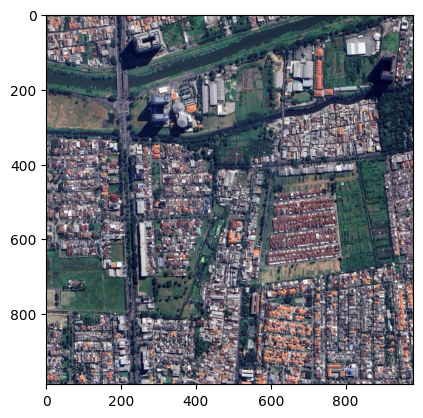

In [35]:
#show sampel data
image = mpimg.imread(r"D:\ML5\CNN_House-Price-Prediction\artifacts\png\13131.png")
plt.imshow(image)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from stn import spatial_transformer_network as STN

In [ ]:
# satellite_images.shape

(1658, 224, 224, 3)

## **Resnet**

In [ ]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, GlobalAveragePooling2D, Dropout

# Define input shapes
input_shape_img = (224, 224, 3)  # Image input shape
input_shape_tx = (X_train_tx.shape[1],)  # Transaction data input shape

# Image Input (ResNet Feature Extraction)
image_input = Input(shape=input_shape_img, name="Image_Input")

# Initialize ResNet50 without the top layer
resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape_img)
resnet_base.trainable = False  # Freeze ResNet50 layers during initial training

# Extract features using ResNet50
resnet_features = resnet_base(image_input)
resnet_output = GlobalAveragePooling2D()(resnet_features)
resnet_output = Flatten()(resnet_output)
resnet_output = Dense(256, activation='relu')(resnet_output)
resnet_output = Dense(128, activation='relu')(resnet_output)
resnet_output = Dense(64, activation='relu')(resnet_output) 
resnet_output = Dense(32, activation='relu')(resnet_output) 
resnet_output = Dense(10, activation='relu')(resnet_output) 

#  Transaction Data Input
transaction_input = Input(shape=input_shape_tx, name="Transaction_Input")

#  Merge Image Features & Transaction Data
merged_features = Concatenate()([resnet_output, transaction_input])

#  Fully Connected Layers for Regression
x = Dense(256, activation='relu')(merged_features)
x = Dropout(0.3)(x)  # Adding dropout with 50% dropout rate
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)  # Adding dropout with 30% dropout rate
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)  # Adding dropout with 20% dropout rate
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='linear', name="Price_Output")(x)  # Ensure this is a Keras Tensor

# Define the final model
model = Model(inputs=[image_input, transaction_input], outputs=output)

model.compile(optimizer='adam'(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Image_Input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ Image_Input[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10)        │        330 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Transaction_Input   │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14)        │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ Transaction_Inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │      3,840 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Price_Output        │ (None, 1)         │         33 │ dense_8[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,202,923 (92.33 MB)

 Trainable params: 615,211 (2.35 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Train the model using the matched dataset
model.fit(
    [X_train_img, X_train_tx], y_train, 
    validation_data=([X_test_img, X_test_tx], y_test),
    epochs=10, batch_size=50
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - loss: 7153637055078072320.0000 - mae: 2219001856.0000 - val_loss: 6087473065216704512.0000 - val_mae: 2030266368.0000
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - loss: 7370245243796455424.0000 - mae: 2245920256.0000 - val_loss: 6085504389647171584.0000 - val_mae: 2029783424.0000
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - loss: 6998983597805797376.0000 - mae: 2196877824.0000 - val_loss: 5906597355133599744.0000 - val_mae: 1985582848.0000
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - loss: 6121606853945196544.0000 - mae: 2014433664.0000 - val_loss: 2105211274202710016.0000 - val_mae: 1022422720.0000
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - loss: 2636133828296441856.0000 - mae: 1279679232.0000 - val_loss: 1953476333107412992.0000 - val_mae: 1051154432.0000
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - loss: 2300573049981763584.0000 - mae: 1149409024.0000 - val_loss: 1963972820861976576.0000 - val_m

## **Hpyerparameter Tuning**

In [ ]:
# from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import ResNet50
# import keras_tuner as kt

# def build_model(hp):
#     # Image input processing
#     input_shape_img = (224, 224, 3)
#     image_input = Input(shape=input_shape_img, name="Image_Input")
#     resnet_base = ResNet50(include_top=False, input_shape=input_shape_img, weights='imagenet')
#     resnet_base.trainable = False
#     x = GlobalAveragePooling2D()(resnet_base(image_input))
    
#     # Tuning the number of units in the first post-ResNet dense layer
#     for i in range(hp.Int('num_dense_layers', 1, 3)):
#         x = Dense(
#             units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32),
#             activation='relu'
#         )(x)

#     # Transaction input processing
#     input_shape_tx = (X_train_tx.shape[1],)
#     transaction_input = Input(shape=input_shape_tx, name="Transaction_Input")
    
#     # Concatenate both inputs
#     concatenated = Concatenate()([x, transaction_input])
    
#     # Additional dense layers post-concatenation
#     y = concatenated
#     for i in range(hp.Int('num_concat_dense_layers', 1, 3)):
#         y = Dense(
#             units=hp.Int('concat_units_' + str(i), min_value=32, max_value=256, step=32),
#             activation='relu'
#         )(y)
    
#     output = Dense(1, activation='linear')(y)
#     model = Model(inputs=[image_input, transaction_input], outputs=output)
    
#     # Compiling the model
#     model.compile(
#         optimizer='adam',
#         loss='mse',
#         metrics=['mae']
#     )
#     return model


In [ ]:
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_mae',
#     max_epochs=10,
#     factor=3,
#     directory='keras_tuner_dir',
#     project_name='house_price_tuning'
# )

# # Early stopping to avoid overfitting
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# # Perform the hyperparameter tuning
# tuner.search([X_train_img, X_train_tx], y_train,
#              epochs=10,
#              validation_data=([X_test_img, X_test_tx], y_test),
#              callbacks=[stop_early])


Trial 30 Complete [00h 17m 30s]
val_mae: 1055323264.0

Best val_mae So Far: 1029228352.0
Total elapsed time: 04h 34m 05s


In [ ]:
# # Get the optimal hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Build the model with the best hyperparameters
# best_model = tuner.hypermodel.build(best_hps)

# # Optional: Retrain the model if necessary
# best_model.fit([X_train_img, X_train_tx], y_train, epochs=10, validation_split=0.2)

# # Evaluate the best model
# eval_result = best_model.evaluate([X_test_img, X_test_tx], y_test)
# print('Optimal model metrics:', eval_result)
# print('Optimal model hyperparameters:', best_hps.values)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - loss: 6995467909375983616.0000 - mae: 2207950336.0000 - val_loss: 8216636650474700800.0000 - val_mae: 2374934016.0000
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - loss: 7503421390687567872.0000 - mae: 2248872448.0000 - val_loss: 8216335934044504064.0000 - val_mae: 2374870528.0000
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - loss: 7251115907705995264.0000 - mae: 2236300032.0000 - val_loss: 8211458500463689728.0000 - val_mae: 2373848064.0000
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 6631163423210078208.0000 - mae: 2141614464.0000 - val_loss: 8172760638968299520.0000 - val_mae: 2365715456.0000
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 6688958702168309760.0000 - mae: 2123916032.0000 - val_loss: 7982966240316489728.0000 - val_mae: 2325421568.0000
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 6334415130477985792.0000 - mae: 2078681088.0000 - val_loss: 7338076282346799104.0000 - val_m

In [ ]:
import os
import cv2
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import pandas as pd

# Load dataset
transaction_data = pd.read_csv(r"D:\ML5\final_projectt\artifacts\data\Final_Cleaned_House_Price_Data_with_ID.csv")
transaction_data["image_filename"] = transaction_data["id"].apply(lambda x: f"{x}.png")

# # Remove outliers using IQR
# Q1, Q3 = np.percentile(transaction_data['price'], [25, 75])
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# transaction_data = transaction_data[(transaction_data['price'] <= upper_bound) & (transaction_data['price'] >= lower_bound)]

# Remove extreme outliers (Top 1%)
price_99 = np.percentile(transaction_data['price'], 90)
transaction_data = transaction_data[transaction_data['price'] < price_99]

# Log transform price
# transaction_data['price'] = np.log(transaction_data['price'])

# Load images
image_folder = r"D:\ML5\final_projectt\artifacts\png"
def load_images(image_filenames, img_size=(224, 224)):
    images = []
    valid_filenames = []
    for filename in image_filenames:
        img_path = os.path.join(image_folder, filename)
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0
            images.append(img)
            valid_filenames.append(filename)
    return np.array(images), valid_filenames

image_filenames = transaction_data["image_filename"].tolist()
satellite_images, valid_filenames = load_images(image_filenames)

filtered_data = transaction_data[transaction_data["image_filename"].isin(valid_filenames)].reset_index(drop=True)

# Prepare features & labels
selected_features = ['bedroom', 'bathroom', 'building_area', 'land_area']
X_transaction = filtered_data[selected_features].fillna(0).values
y_prices = filtered_data["price"].values.reshape(-1, 1)

# Standardize X
scaler_tx = MinMaxScaler()
X_transaction = scaler_tx.fit_transform(X_transaction)

X_train_img, X_test_img, X_train_tx, X_test_tx, y_train, y_test = train_test_split(
    satellite_images, X_transaction, y_prices, test_size=0.2, random_state=42
)
# Define input shapes
input_shape_img = (224, 224, 3)  # Image input shape
input_shape_tx = (X_train_tx.shape[1],)  # Transaction data input shape

# Image Input (ResNet Feature Extraction)
image_input = Input(shape=input_shape_img, name="Image_Input")

# # Define model
image_input = Input(shape=(224, 224, 3))
vgg16 =VGG16(weights="imagenet", include_top=False, input_shape=input_shape_img)
vgg16.trainable = False  # Freeze ResNet50 layers during initial training

# Extract features using ResNet50
resnet_features = vgg16(image_input)
resnet_output = GlobalAveragePooling2D()(resnet_features)
resnet_output = Dense(256, activation='relu')(resnet_output)
resnet_output = Dense(128, activation='relu')(resnet_output)
resnet_output = Dense(64, activation='relu')(resnet_output) 
resnet_output = Dense(32, activation='relu')(resnet_output) 
resnet_output = Dense(10, activation='relu')(resnet_output)  

#  Transaction Data Input
transaction_input = Input(shape=input_shape_tx, name="Transaction_Input")

#  Merge Image Features & Transaction Data
merged_features = Concatenate()([resnet_output, transaction_input])

# Fully Connected Layers for Regression
x = Dense(128, activation='relu')(merged_features)
x = Dropout(0.2)(x)  # Adding dropout with 30% dropout rate
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)  # Adding dropout with 20% dropout rate
x = Dense(32, activation='relu')(x)

output = Dense(1,activation='linear', name="Price_Output")(x)  # Ensure this is a Keras Tensor

# Define the final model
model = Model(inputs=[image_input, transaction_input], outputs=output)

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

model.fit([X_train_img, X_train_tx], y_train, validation_data=([X_test_img, X_test_tx], y_test), epochs=200)


Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 253s 7s/step - loss: 4212958297096978432.0000 - mae: 1813029888.0000 - mse: 4212958297096978432.0000 - val_loss: 4515958138066698240.0000 - val_mae: 1879904128.0000 - val_mse: 4515958138066698240.0000
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 248s 7s/step - loss: 4138775896838373376.0000 - mae: 1805839488.0000 - mse: 4138775896838373376.0000 - val_loss: 4514640923136622592.0000 - val_mae: 1879555072.0000 - val_mse: 4514640923136622592.0000
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 248s 7s/step - loss: 3855419655732592640.0000 - mae: 1734120576.0000 - mse: 3855419655732592640.0000 - val_loss: 4419386932287504384.0000 - val_mae: 1854141952.0000 - val_mse: 4419386932287504384.0000
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 248s 7s/step - loss: 3996637630669258752.0000 - mae: 1732923904.0000 - mse: 3996637630669258752.0000 - val_loss: 2367110545892442112.0000 - val_mae: 1196377472.0000 - val_mse: 2367110545892442112.0000
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 3

In [9]:
# Save the scaler to a pickle file
with open('scaler1.pkl', 'wb') as file:
    pickle.dump(scaler_tx, file)

# Save the scaler to a pickle file
with open('model2.pkl', 'wb') as file:
    pickle.dump(model, file)

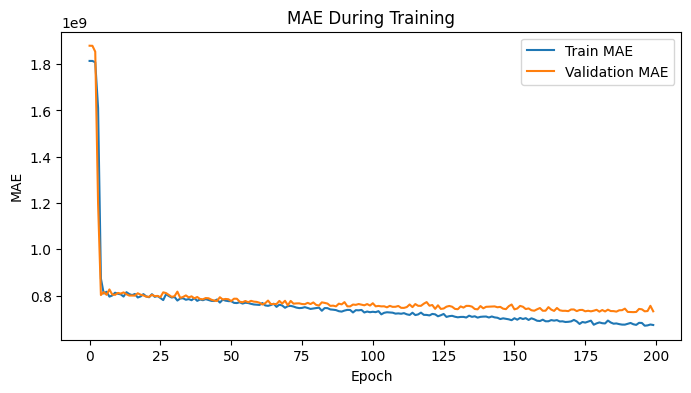

In [10]:
import matplotlib.pyplot as plt

# Plotting RMSE
plt.figure(figsize=(8, 4))

plt.plot(model.history.history['mae'], label='Train MAE')
plt.plot(model.history.history['val_mae'], label='Validation MAE')
plt.title('MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()
